In [114]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#from time_series_modelling import SARIMAX_hyperparameter_tune

import sys
sys.path.append('/Users/AaranDaniel/Desktop/DSI/projects/Group_Project_5_GA/code/')
from time_series_plots import plot_time_series

In [115]:
df = pd.read_csv('../data/Master_data.csv', index_col='date', parse_dates=True)
df.drop(columns=['year', 'month'], inplace=True)
df.head()

,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,tax_other_to_government,tax_personal_current,tax_gov_social_insurance_domestic,tax_total_all_taxes,cc_rate_all_ns,mortgage_rate_30_yr,cc_bals_30d_due_percentage,cc_bals_90d_due_percentage,cc_balance_total_billions,credit_yoy
date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,283960000.0,4.2,NaN,3.732227,3.252886,17.777778,4.538341,2.889825,13.143736,2.760736,...,5.118800e+10,1.289199e+12,7.281720e+11,2.068559e+12,.,7.0325,NaN,NaN,NaN,12.391364
2001-02-01,284166000.0,4.2,NaN,3.533569,3.457307,13.110540,4.600390,3.006615,8.400292,0.200602,...,5.152400e+10,1.303434e+12,7.330290e+11,2.087987e+12,15.63,7.0500,NaN,NaN,NaN,12.757135
2001-03-01,284380000.0,4.3,NaN,2.920561,3.496868,5.973813,4.540163,3.123123,-6.099935,-1.601602,...,5.189600e+10,1.313079e+12,7.357760e+11,2.100751e+12,.,6.9520,NaN,NaN,NaN,12.611905
2001-04-01,284602000.0,4.4,NaN,3.269119,3.595623,10.273405,4.643963,3.181273,3.851262,-0.710660,...,5.212400e+10,1.315105e+12,7.335270e+11,2.100756e+12,.,7.0775,NaN,NaN,NaN,12.895804
2001-05-01,284834000.0,4.3,NaN,3.615160,3.742204,15.785124,4.668210,3.108189,15.420561,-0.809717,...,5.246000e+10,1.310869e+12,7.328300e+11,2.096159e+12,15.06,7.1450,NaN,NaN,NaN,12.498904


In [116]:
df.corr(numeric_only=True)['credit_yoy'].sort_values(ascending=False)

credit_yoy                                                         1.000000
shelter_yoy                                                        0.520146
cpi_yoy                                                            0.448303
food_yoy                                                           0.320199
energy_yoy                                                         0.299519
mortgage_rate_30_yr                                                0.248460
gasoline_yoy                                                       0.202741
all_less_food_&_shelter_yoy                                        0.184390
imports_yoy                                                        0.164761
tax_personal_current                                               0.136099
cc_balance_total_billions                                          0.111787
hourly_earnings_yoy                                                0.108193
medical_care_yoy                                                   0.103553
new_&_used_v

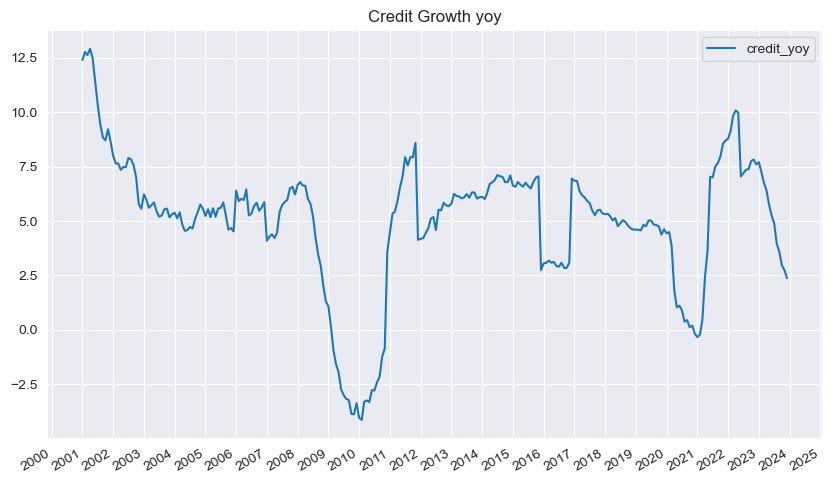

<Figure size 1000x600 with 0 Axes>

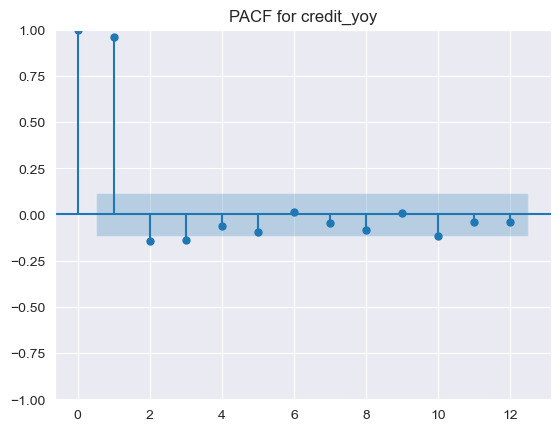

In [117]:
plot_time_series(df, columns = ['credit_yoy'],title = 'Credit Growth yoy', pacf=True);

First endogenous baseline model will use p of 1 based on the idea that:

"If the PACF (partial autocorrelation function) has a sharp cut-off and the lag-1 PACF value is positive, choose $p$ to be the lag in the PACF before the cut-off. If the PACF does not have a sharp cut-off or the lag-1 ACF value is not positive, then let $p=0$."

q will equal 

In [118]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(df['credit_yoy']))

Test Statistic   -2.840773
p-value           0.052681
dtype: float64

In [119]:
# lets do d = 1 based on below results
df_lag = df.copy()
df_lag['credit_yoy_lag1'] = df_lag['credit_yoy'].diff(1)
interpret_dftest(adfuller(df_lag['credit_yoy_lag1'].dropna()))

Test Statistic   -6.401630e+00
p-value           1.988921e-08
dtype: float64

d = 1 based on above p-value which is less when 0.05

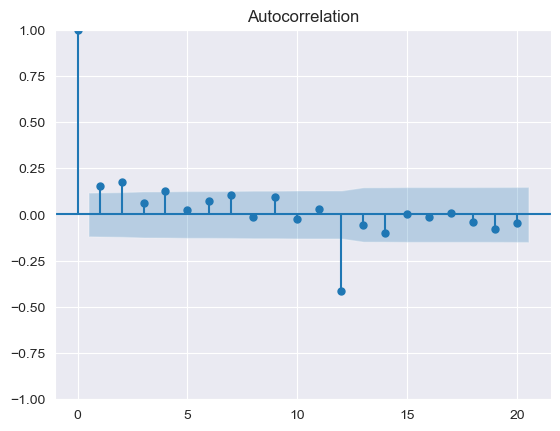

In [120]:
plot_acf(df_lag['credit_yoy_lag1'].dropna(), lags=20);

q will equal 0 because the first lag is positive, in the auto correlation function.

## Baseline ARIMA model 

In [121]:
df.columns

Index(['population', 'unemployment_rate', 'hourly_earnings_yoy', 'cpi_yoy',
       'shelter_yoy', 'energy_yoy', 'medical_care_yoy', 'food_yoy',
       'gasoline_yoy', 'imports_yoy', 'new_&_used_vehicles_yoy',
       'all_less_food_&_shelter_yoy', 'total_personal_income',
       'total_employee_compensation', 'wages_and_salaries_all',
       'wages_salaries_private_employees',
       'wages_salaries_government_employees',
       'employer_contributions_for_employee_pension_and_insurance_funds',
       'employer_contributions_for_government_social_insurance',
       'rental_income_(capital_consumption_adjusted)',
       'personal_dividend_income', 'personal_interest_income',
       'total_gov_social_benefits', 'social_security', 'medicare', 'medicaid',
       'unemployment_insurance', 'veterans'_benefits',
       'total_disposible_personal_income_chained_2017',
       'total_personal_savings',
       'personal_saving_as_a_percentage_of_disposable_personal_income',
       'disp_inc_per_ca

In [122]:
X = df.drop(columns=['credit_yoy', 'cc_rate_all_ns'])
y = df['credit_yoy']

In [123]:
df['credit_yoy']

date
2001-01-01    12.391364
2001-02-01    12.757135
2001-03-01    12.611905
2001-04-01    12.895804
2001-05-01    12.498904
                ...    
2023-08-01     3.964872
2023-09-01     3.577056
2023-10-01     2.967773
2023-11-01     2.745921
2023-12-01     2.375184
Name: credit_yoy, Length: 276, dtype: float64

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False) 
y_train.index.freq = 'MS'
y_test.index.freq = 'MS'
y_train.index.freq = 'MS'
y_test.index.freq = 'MS'

In [125]:
model = ARIMA(endog=y_train.astype(float).dropna(), 
              order = (1, 1, 0),) # p, d, q

In [126]:
arima_1_1_0 = model.fit()

In [127]:
y_test

date
2020-07-01     0.902552
2020-08-01     0.380780
2020-09-01     0.449483
2020-10-01     0.128756
2020-11-01     0.205011
2020-12-01    -0.175061
2021-01-01    -0.330509
2021-02-01    -0.205600
2021-03-01     0.466657
2021-04-01     2.437071
2021-05-01     3.610941
2021-06-01     7.024071
2021-07-01     7.000940
2021-08-01     7.500785
2021-09-01     7.663382
2021-10-01     7.959316
2021-11-01     8.549534
2021-12-01     8.690476
2022-01-01     8.776977
2022-02-01     9.154833
2022-03-01     9.833094
2022-04-01    10.073821
2022-05-01     9.961450
2022-06-01     7.045462
2022-07-01     7.192072
2022-08-01     7.349697
2022-09-01     7.381099
2022-10-01     7.748737
2022-11-01     7.818444
2022-12-01     7.595966
2023-01-01     7.697741
2023-02-01     7.234624
2023-03-01     6.762653
2023-04-01     6.414150
2023-05-01     5.762839
2023-06-01     5.254929
2023-07-01     4.910374
2023-08-01     3.964872
2023-09-01     3.577056
2023-10-01     2.967773
2023-11-01     2.745921
2023-12-01 

In [128]:
preds = arima_1_1_0.predict(start = datetime(2020, 7, 1), end = datetime(2023, 12, 1))

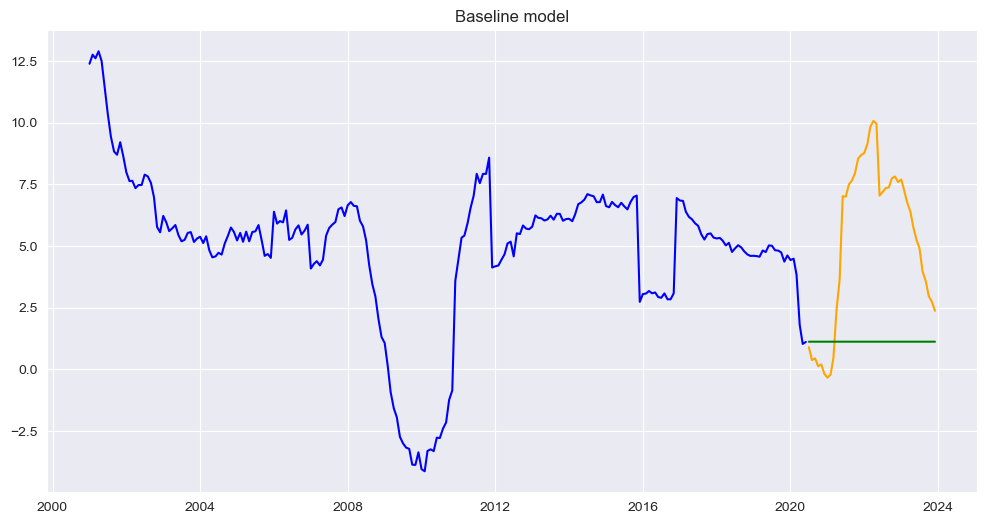

In [129]:
plt.figure(figsize=(12,6))

plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Baseline model', fontsize=12);

In [130]:
print(arima_1_1_0.aic)


506.329538593552


## SARIMAX model

In [131]:
from pmdarima import auto_arima

In [181]:
# source: https://sailajakarra.medium.com/time-series-predictions-using-arima-sarimax-e6724844cae0 

sarimax_model = auto_arima(y_train,
                       start_P=0,
                       start_q=0,
                       max_d = 3,
                       max_p=3,
                       max_q=3,
                       max_D = 3, 
                       max_P=3, 
                       max_Q=3, 
                       m=1, # is monthly 
                       seasonal=True,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
sarimax_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=506.313, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=507.979, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=507.473, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=507.955, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=507.048, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=508.219, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=506.916, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=505.245, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=506.927, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=507.171, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=508.265, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=503.803, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=506.864, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=506.330, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=505.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -248.901
Date:                Thu, 15 Feb 2024   AIC                            503.803
Time:                        19:17:23   BIC                            514.156
Sample:                    01-01-2001   HQIC                           507.978
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8034      0.206      3.906      0.000       0.400       1.207
ma.L1         -0.6971      0.261     -2.669      0.008      -1.209      -0.185
sigma2         0.4958      0.015     32.835      0.000       0.466       0.525
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              4575.69
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [178]:
X_train_exog = X_train[['personal_saving_as_a_percentage_of_disposable_personal_income', 
                        'unemployment_insurance',
                        'mortgage_rate_30_yr', 
                        'shelter_yoy', 
                        'unemployment_rate', 
                        'cpi_yoy']]
X_test_exog = X_test[['personal_saving_as_a_percentage_of_disposable_personal_income', 
                      'unemployment_insurance',
                      'mortgage_rate_30_yr', 
                      'shelter_yoy', 
                      'unemployment_rate', 
                      'cpi_yoy']]
                      

In [179]:
sarimax = SARIMAX(endog = y_train,
                order = (1,1,1),              # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S)
                exog = X_train_exog.dropna(), 
                seasonal = True)

# Fit SARIMAX model.
results = sarimax.fit(disp=False)

# Generate predictions based on test set.
preds = results.predict(
                    start = datetime((int(str(y_test.index[0])[0:4])), 
                                        int(str(y_test.index[0])[5:7]), 
                                        int(str(y_test.index[0])[8:10])),
                    end = datetime((int(str(y_test.index[-1])[0:4])), 
                                    int(str(y_test.index[-1])[5:7]), 
                                    int(str(y_test.index[-1])[8:10])),
                    exog = X_test_exog.dropna())

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


494.7173354845155


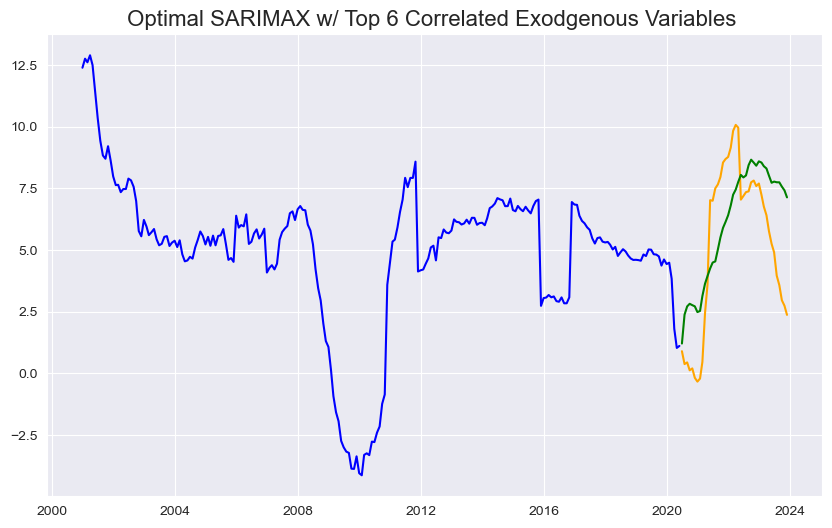

In [180]:
# Evaluate predictions.
print(results.aic)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Optimal SARIMAX w/ Top 6 Correlated Exodgenous Variables ', fontsize=16)
plt.show();

## Try with pre-covid only data

In [182]:
X_train_precov, X_test_precov, y_train_precov, y_test_precov = train_test_split(X,
                                                    y,
                                                    test_size = 0.17,
                                                    shuffle = False) 

sarimax_model_precov = auto_arima(y_train_precov,
                       start_P=0,
                       start_q=0,
                       max_d = 3,
                       max_p=3,
                       max_q=3,
                       max_D = 3, 
                       max_P=3, 
                       max_Q=3, 
                       m=1, # is monthly 
                       seasonal=True,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
sarimax_model_precov.summary()



Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=491.372, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=492.544, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=492.854, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=493.192, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=491.099, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=490.510, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=491.876, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=491.899, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=492.312, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=493.121, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=488.779, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=491.679, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=491.319, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=490.138, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=490.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -241.390
Date:                Thu, 15 Feb 2024   AIC                            488.779
Time:                        19:17:38   BIC                            499.067
Sample:                    01-01-2001   HQIC                           492.930
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8065      0.209      3.858      0.000       0.397       1.216
ma.L1         -0.7081      0.266     -2.661      0.008      -1.230      -0.187
sigma2         0.4864      0.015     32.745      0.000       0.457       0.516
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              5004.61
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                            -0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                        25.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

506.57607010434174


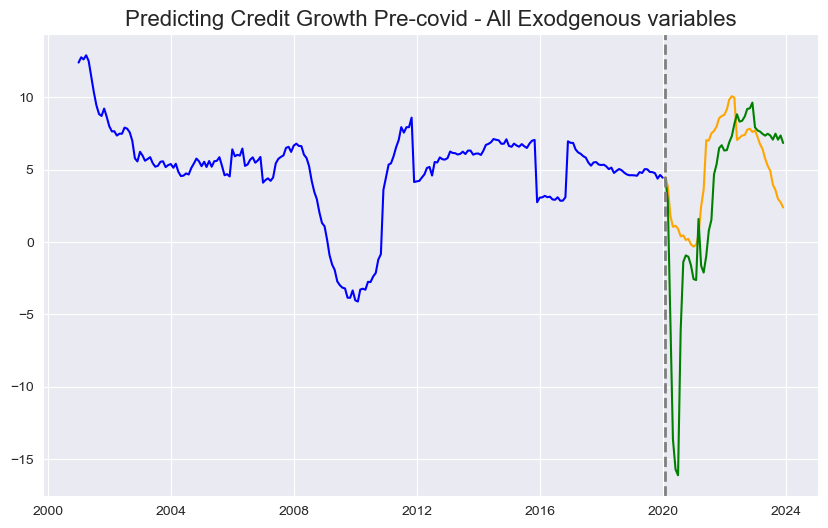

In [187]:
X_train_exog_precov = X_train_precov.drop(columns = [
    'cc_balance_total_billions',
    'cc_bals_90d_due_percentage',
    'cc_bals_30d_due_percentage',
    'hourly_earnings_yoy'])
X_test_exog_precov = X_test_precov.drop(columns = [
    'cc_balance_total_billions',
    'cc_bals_90d_due_percentage',
    'cc_bals_30d_due_percentage',
    'hourly_earnings_yoy'])


sarimax_precov = SARIMAX(endog = y_train_precov,
                order = (1,1,1),              # (p, d, q)
                seasonal_order = (0,0,0,0),  # (P, D, Q, S)
                exog = X_train_exog_precov.dropna(), 
                seasonal = True)

# Fit SARIMAX model.
results_precov = sarimax_precov.fit(disp=False)

# Generate predictions based on test set.
preds_precov = results_precov.predict(
                    start = datetime((int(str(y_test_precov.index[0])[0:4])), 
                                        int(str(y_test_precov.index[0])[5:7]), 
                                        int(str(y_test_precov.index[0])[8:10])),
                    end = datetime((int(str(y_test_precov.index[-1])[0:4])), 
                                    int(str(y_test_precov.index[-1])[5:7]), 
                                    int(str(y_test_precov.index[-1])[8:10])),
                    exog = X_test_exog_precov.dropna())
# Evaluate predictions.
print(results_precov.aic)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train_precov, color = 'blue')
plt.plot(y_test_precov, color = 'orange')
plt.plot(preds_precov, color = 'green')
plt.title(label = 'Predicting Credit Growth Pre-covid - All Exodgenous variables', fontsize=16)
plt.axvline(pd.Timestamp('2020-02-01'), color='grey', linestyle='--', lw=2, label='COVID-19 Start')
plt.show();

# Training Model on All Data and Predicting Future Credit Growth

In [ ]:
preds_future = results.predict(
                    start = datetime((int(str(y_test.index[-1])[0:4])), 
                                    int(str(y_test.index[-1])[5:7]), 
                                    int(str(y_test.index[-1])[8:10])),
                    start = datetime((int(str(y_test.index[0])[0:4])), 
                                        int(str(y_test.index[0])[5:7]), 
                                        int(str(y_test.index[0])[8:10])),                
                    exog = X_test_exog.dropna())